In [1]:
import tensorflow as tf
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
from keras.datasets import cifar10
from keras.utils import np_utils

(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255.
X_test /= 255.
y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)

In [3]:
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPool2D
from keras.optimizers import Adam
from keras.layers.core import Dense, Activation, Dropout, Flatten

In [4]:
model1=Sequential()

model1.add(Conv2D(32,(3,3),padding='same',input_shape=(32,32,3)))
model1.add(Activation('relu'))
model1.add(Conv2D(32,(3,3),padding='same'))
model1.add(Activation('relu'))
model1.add(MaxPool2D(pool_size=(2,2)))
model1.add(Dropout(0.25))

'''
model1.add(Conv2D(64,(3,3),padding='same'))
model1.add(Activation('relu'))
model1.add(Conv2D(64,(3,3),padding='same'))
model1.add(Activation('relu'))
model1.add(MaxPool2D(pool_size=(2,2)))
model1.add(Dropout(0.25))
'''

model1.add(Flatten())
model1.add(Dense(512))
model1.add(Activation('relu'))
model1.add(Dropout(0.5))
model1.add(Dense(10,activation='softmax'))

In [5]:
model2=Sequential()

model2.add(Conv2D(32,(3,3),padding='same',input_shape=(32,32,3)))
model2.add(Activation('relu'))
model2.add(Conv2D(32,(3,3),padding='same'))
model2.add(Activation('relu'))
model2.add(MaxPool2D(pool_size=(2,2)))
model2.add(Dropout(0.25))

model2.add(Conv2D(64,(3,3),padding='same'))
model2.add(Activation('relu'))
model2.add(Conv2D(64,(3,3),padding='same'))
model2.add(Activation('relu'))
model2.add(MaxPool2D(pool_size=(2,2)))
model2.add(Dropout(0.25))

model2.add(Flatten())
model2.add(Dense(512))
model2.add(Activation('relu'))
model2.add(Dropout(0.5))
model2.add(Dense(10,activation='softmax'))

In [6]:
model1.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])
model2.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])

In [7]:
class Landscape:
  def __init__(self, model):
    self.weight_list = []
    self.weight_list.append(self.getWeight1D(model))

  def getWeight1D(self, model):
    weight1d = np.empty(0)
    for layer in model.layers:
      for i in range(len(layer.weights)):
        weight = layer.get_weights()[i]
        weight1d = np.concatenate([weight1d, np.ravel(weight)])
    return weight1d

  def setWeight(self, model, weight1d):
    for layer in model.layers:
      weight_list = []
      for i in range(len(layer.weights)):
        shape = layer.get_weights()[i].shape
        size = layer.get_weights()[i].size
        weight_list.append(weight1d[:size].reshape(shape))
        weight1d = weight1d[size:]
      layer.set_weights(weight_list)

  def appendWeight(self, model):
    self.weight_list.append(self.getWeight1D(model))

  def PCA(self):
    self.weight_list_np = np.array(self.weight_list)
    self.weight_base = self.weight_list_np[-1, :]
    self.weight_list_np = self.weight_list_np-self.weight_base
    self.pca = PCA(n_components=2, svd_solver="randomized")
    self.pca.fit(self.weight_list_np)

  def plotPath(self, model, x, y, resolution=10):
    path = self.pca.transform(self.weight_list_np)
    plt.plot(path[:, 0], path[:, 1], color="r")
    x_max = max(np.max(path[:, 0]), -np.min(path[:, 0]))
    y_max = max(np.max(path[:, 1]), -np.min(path[:, 1]))
    ax = np.linspace(-3*x_max, 3*x_max, resolution)
    ay = np.linspace(-3*y_max, 3*y_max, resolution)
    xx, yy = np.meshgrid(ax, ay)
    zz = np.empty((resolution, resolution))
    for i in range(resolution):
      for j in range(resolution):
        weight = self.pca.inverse_transform(np.array([xx[i][j], yy[i][j]]))
        self.setWeight(model, self.weight_base+weight)
        zz[i][j] = model.evaluate(x, y, batch_size=256, verbose=0)[0]
    plt.contourf(xx, yy, np.log(zz), levels=30)
    plt.colorbar()
    plt.xlabel("1st component")
    plt.ylabel("2nd component")
    plt.show()

In [8]:
LS1 = Landscape(model1)
LS2 = Landscape(model2)

In [9]:
print("Model1")
for i in range(10):
  model1.fit(X_train, y_train, batch_size=256, epochs=2, validation_split=0.2)
  LS1.appendWeight(model1)
print("Model2")
for i in range(10):
  model2.fit(X_train, y_train, batch_size=256, epochs=2, validation_split=0.2)
  LS2.appendWeight(model2)

Model1
Epoch 1/2
157/157 [==============================] - 13s 19ms/step - loss: 1.6001 - accuracy: 0.4227 - val_loss: 1.3165 - val_accuracy: 0.5474
Epoch 2/2
157/157 [==============================] - 3s 17ms/step - loss: 1.2169 - accuracy: 0.5681 - val_loss: 1.1262 - val_accuracy: 0.6036
Epoch 1/2
157/157 [==============================] - 3s 17ms/step - loss: 1.0665 - accuracy: 0.6214 - val_loss: 1.0159 - val_accuracy: 0.6474
Epoch 2/2
157/157 [==============================] - 3s 16ms/step - loss: 0.9642 - accuracy: 0.6615 - val_loss: 0.9707 - val_accuracy: 0.6627
Epoch 1/2
157/157 [==============================] - 3s 17ms/step - loss: 0.8779 - accuracy: 0.6913 - val_loss: 0.9075 - val_accuracy: 0.6840
Epoch 2/2
157/157 [==============================] - 3s 16ms/step - loss: 0.8152 - accuracy: 0.7123 - val_loss: 0.8891 - val_accuracy: 0.6937
Epoch 1/2
157/157 [==============================] - 3s 17ms/step - loss: 0.7457 - accuracy: 0.7385 - val_loss: 0.9145 - val_accuracy: 0.683

In [10]:
_, X_train_subset, _, y_train_subset = train_test_split(X_train, y_train, test_size=4096, random_state=1)

Train


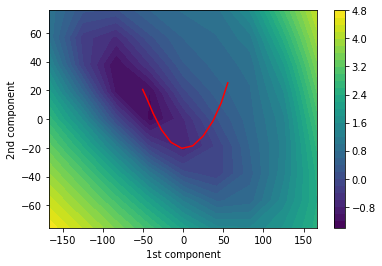

Test


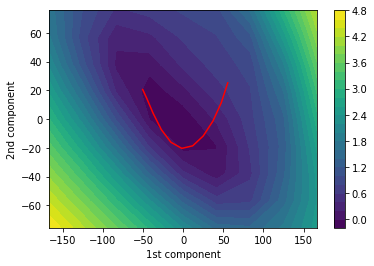

In [11]:
LS1.PCA()
print("Train")
LS1.plotPath(model1, X_train_subset, y_train_subset, resolution=9)
print("Test")
LS1.plotPath(model1, X_test, y_test, resolution=9)

Train


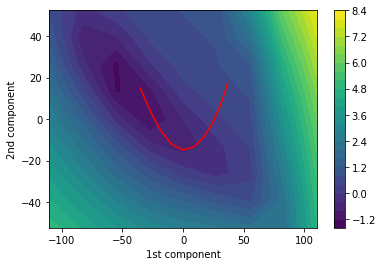

Test


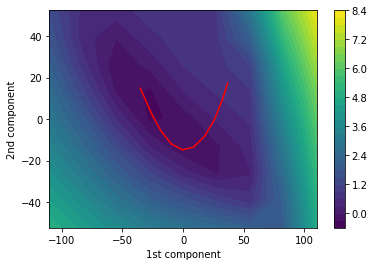

In [12]:
LS2.PCA()
print("Train")
LS2.plotPath(model2, X_train_subset, y_train_subset, resolution=9)
print("Test")
LS2.plotPath(model2, X_test, y_test, resolution=9)